In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rsna_intracranial_aneurysm_detection_path = kagglehub.competition_download('rsna-intracranial-aneurysm-detection')
dennisfong_rsna_2025_ia_cta_224_tensors_path = kagglehub.dataset_download('dennisfong/rsna-2025-ia-cta-224-tensors')

print('Data source import complete.')


# Configs and Import Libraries

In [ ]:
# ==== Imports ====
from tqdm.auto import tqdm
import os
import shutil
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import gc
import ast
import sys

import matplotlib.pyplot as plt
from matplotlib import patches

from torch.utils.data import Dataset
import torch

# ==== Config ====
USE_CV = True
NUM_FOLDS = 5
EPOCHS = 5
BATCH_SIZE = 8
LR = 1e-4
IMG_SIZE = 224 #224
SERIES_ROOT = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"
CACHE_DIR = "/kaggle/input/rsna-2025-ia-cta-224-tensors"
windowing = False

ARCHITECTURES = ['tf_efficientnet_b0'] #,'resnet18'

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery', 'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery', 'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
    'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery', 'Basilar Tip',
    'Other Posterior Circulation', 'Aneurysm Present'
]
ID_COL = "SeriesInstanceUID"



# Use GPU or CPU and related Settings

In [ ]:
# ==== Detect GPUs ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
USE_MULTIGPU = num_gpus > 1
print(f"Detected {num_gpus} GPU(s)")

# ==== Set up CPU/GPU ====
import os, torch

NUM_CPUS = os.cpu_count() or 2
# Use most cores for compute; keep a couple free for I/O/OS
torch.set_num_threads(max(1, NUM_CPUS - 2))
torch.set_num_interop_threads(2)


NUM_WORKERS = max(4, min(8, NUM_CPUS // 2))  # tune as needed

os.environ["OMP_NUM_THREADS"] = str(max(1, NUM_CPUS - 2))
os.environ["MKL_NUM_THREADS"] = str(max(1, NUM_CPUS - 2))

print("CPUs:", NUM_CPUS)
print("Torch threads:", torch.get_num_threads(), "interop:", torch.get_num_interop_threads())



Detected 1 GPU(s)
CPUs: 4
Torch threads: 2 interop: 2


# Define some useful functions

In [ ]:
# ==== Utils ====
def get_model(arch):
    model = timm.create_model(arch, in_chans=IN_CHANS, num_classes=len(LABEL_COLS), pretrained=False)
    if USE_MULTIGPU:
        model = nn.DataParallel(model)
    return model.to(device)

def sort_dicom_slices(filepaths):
    dicoms = [pydicom.dcmread(fp, force=True) for fp in filepaths]
    try:
        dicoms.sort(key=lambda d: float(d.ImagePositionPatient[2]))
    except Exception:
        dicoms.sort(key=lambda d: int(getattr(d, "InstanceNumber", 0)))
    return dicoms

def to_hu(dcm):
    img = dcm.pixel_array.astype(np.float32)
    slope = float(getattr(dcm, "RescaleSlope", 1.0))
    intercept = float(getattr(dcm, "RescaleIntercept", 0.0))
    return img * slope + intercept

def window_img(hu, wl, ww):
    lo, hi = wl - ww/2.0, wl + ww/2.0
    hu = np.clip(hu, lo, hi)
    return ((hu - lo) / (hi - lo)).astype(np.float32)

# Helper function to parse the coordinates from the format {x: 12.213, y: 342.132}
def parse_coordinates(coord_str):
    coord_dict = ast.literal_eval(coord_str)
    return np.array([coord_dict['x'], coord_dict['y']])

# Load the train_localizers.csv
localizer_df = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv')

# Apply the parse function to the coordinates column
localizer_df['coordinates'] = localizer_df['coordinates'].apply(parse_coordinates)


def valid_coords(coords):
    return np.all(np.isfinite(coords)) and not (coords[0] == 0.0 and coords[1] == 0.0)

def coords_to_px(coords, img_size=IMG_SIZE):
    x, y = float(coords[0]), float(coords[1])
    if 0.0 <= x <= 1.0 and 0.0 <= y <= 1.0:
        x *= img_size; y *= img_size
    return int(round(x)), int(round(y))

def make_bbox_px(x, y, img_size=IMG_SIZE, box_frac=0.15, min_px=24, max_px=None):
    r = max(min_px/2, box_frac * img_size / 2.0)
    if max_px is not None:
        r = min(r, max_px/2)
    x1 = int(np.clip(x - r, 0, img_size - 1))
    y1 = int(np.clip(y - r, 0, img_size - 1))
    x2 = int(np.clip(x + r, 0, img_size - 1))
    y2 = int(np.clip(y + r, 0, img_size - 1))
    # enforce minimum width/height of 2 px
    if x2 <= x1: x2 = min(img_size - 1, x1 + 1)
    if y2 <= y1: y2 = min(img_size - 1, y1 + 1)
    return x1, y1, x2, y2

def crop_and_resize_chw(img_chw, x1, y1, x2, y2, out_size=IMG_SIZE):
    # img_chw: [C,H,W] float16/float32
    img_hwc = np.transpose(np.asarray(img_chw), (1, 2, 0))
    crop = img_hwc[y1:y2, x1:x2]
    if crop.size == 0 or crop.shape[0] < 2 or crop.shape[1] < 2:
        # fallback to full image (cast to float32 to avoid later issues)
        full = img_hwc.astype(np.float32, copy=False)
        full = cv2.resize(full, (out_size, out_size), interpolation=cv2.INTER_AREA)
        return np.transpose(full, (2, 0, 1))

    crop = crop.astype(np.float32, copy=False)
    crop = np.ascontiguousarray(crop)
    crop = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return np.transpose(crop, (2, 0, 1))

def crop_and_resize_hwc(img_hwc: np.ndarray, x1: int, y1: int, x2: int, y2: int, out_size: int) -> np.ndarray:
    crop = img_hwc[y1:y2, x1:x2]
    if crop.size == 0 or crop.shape[0] < 2 or crop.shape[1] < 2:
        crop = img_hwc  # fallback to full img
    crop = crop.astype(np.float32, copy=False)
    crop = np.ascontiguousarray(crop)
    crop = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return crop  # HWC float32


def make_loader(ds, shuffle, num_workers):
    kwargs = dict(batch_size=BATCH_SIZE, shuffle=shuffle, pin_memory=True)
    if num_workers > 0:
        kwargs.update(num_workers=num_workers, persistent_workers=False, prefetch_factor=2)
    return DataLoader(ds, **kwargs)

# In notebook, prefer workers=0 for clean shutdown
from IPython import get_ipython
IN_NOTEBOOK = get_ipython() is not None
SAFE_WORKERS = 0 if IN_NOTEBOOK else NUM_WORKERS



def compute_weighted_auc(y_true, y_prob, class_names):
    y_true = np.atleast_2d(y_true)
    y_prob = np.atleast_2d(y_prob)
    aucs, skipped = {}, []
    for i, name in enumerate(class_names):
        yi = y_true[:, i]
        if len(np.unique(yi)) < 2:
            skipped.append(name)
            continue
        aucs[name] = roc_auc_score(yi, y_prob[:, i])
    ap_name = "Aneurysm Present"
    ap_auc = aucs.get(ap_name, np.nan)
    others = [v for k, v in aucs.items() if k != ap_name]
    others_mean = np.mean(others) if others else np.nan
    weighted_auc = 0.5 * (ap_auc + others_mean)
    return weighted_auc, ap_auc, others_mean, aucs, skipped


# 2.5D window config
OFFSETS = (-2, -1, 0, 1, 2)  # window length = 5 (set to (-1,0,1) for 3)
WINDOW_LEN = len(OFFSETS)

def load_cached_img(img_path: str) -> np.ndarray:
    if img_path.endswith(".npz"):
        return np.load(img_path)["arr_0"]          # [C_all, H, W]
    return np.load(img_path, mmap_mode="r")        # [C_all, H, W]

def take_window(img_chw: np.ndarray, center_idx: int, offsets=OFFSETS) -> np.ndarray:
    C = img_chw.shape[0]
    idxs = [min(max(0, center_idx + o), C - 1) for o in offsets]
    return img_chw[idxs, :, :]                     # [WINDOW_LEN, H, W]


@torch.no_grad()
def infer_series_all_slices(model: nn.Module, sid: str, cache_dir=CACHE_DIR, img_size=IMG_SIZE,
                            offsets=OFFSETS, batch_size=16, aggregate="max", use_roi=True):
    img_path_npz = os.path.join(cache_dir, f"{sid}_img.npz")
    img_path_npy = os.path.join(cache_dir, f"{sid}_img.npy")
    img_path = img_path_npz if os.path.exists(img_path_npz) else img_path_npy

    coord_path = os.path.join(cache_dir, f"{sid}_coords.npy")

    img_full = load_cached_img(img_path)                  # [C_all, H, W]
    coords = np.load(coord_path).astype(np.float32) if os.path.exists(coord_path) else np.array([0., 0.], np.float32)
    C_all = img_full.shape[0]

    def prep_window(center_idx: int) -> tuple[np.ndarray, np.ndarray]:
        win = take_window(img_full, center_idx, offsets)   # [WINDOW_LEN, H, W]
        if use_roi and valid_coords(coords):
            cx, cy = coords_to_px(coords, img_size)
            x1, y1, x2, y2 = make_bbox_px(cx, cy, img_size, 0.15, 24)
            win_roi = crop_and_resize_chw(win, x1, y1, x2, y2, img_size)  # [WINDOW_LEN,H,W]
        else:
            win_hwc = np.transpose(win, (1, 2, 0)).astype(np.float32, copy=False)
            win_hwc = np.ascontiguousarray(win_hwc)
            resized = cv2.resize(win_hwc, (img_size, img_size), interpolation=cv2.INTER_AREA)
            win_roi = np.transpose(resized, (2, 0, 1))
        win_full = win_roi  # if you want two branches identical spatially; else keep uncropped for full
        return win_full, win_roi

    xs_full, xs_roi = [], []
    for c in range(C_all):
        w_full, w_roi = prep_window(c)
        xs_full.append(w_full)
        xs_roi.append(w_roi)

    xs_full = torch.from_numpy(np.stack(xs_full).astype(np.float32)).to(device)  # [N, C, H, W]
    xs_roi  = torch.from_numpy(np.stack(xs_roi).astype(np.float32)).to(device)

    logits_all = []
    for i in range(0, xs_full.shape[0], batch_size):
        xb_full = xs_full[i:i+batch_size]
        xb_roi  = xs_roi[i:i+batch_size]
        coords_b = torch.from_numpy(np.repeat(coords[None, :], xb_full.shape[0], axis=0)).to(device)
        logits = model(xb_full, xb_roi, coords_b)  # [B, num_classes]
        logits_all.append(logits)
    logits_all = torch.cat(logits_all, dim=0)
    probs_all = torch.sigmoid(logits_all).cpu().numpy()     # [N_windows, num_classes]

    if aggregate == "max":
        series_prob = probs_all.max(axis=0)
    elif aggregate == "mean":
        series_prob = probs_all.mean(axis=0)
    elif aggregate == "topk_mean":
        k = max(1, xs_full.shape[0] // 5)
        series_prob = np.sort(probs_all, axis=0)[-k:].mean(axis=0)
    else:
        series_prob = probs_all.mean(axis=0)
    return series_prob


# Preview Slices and Region of Interest

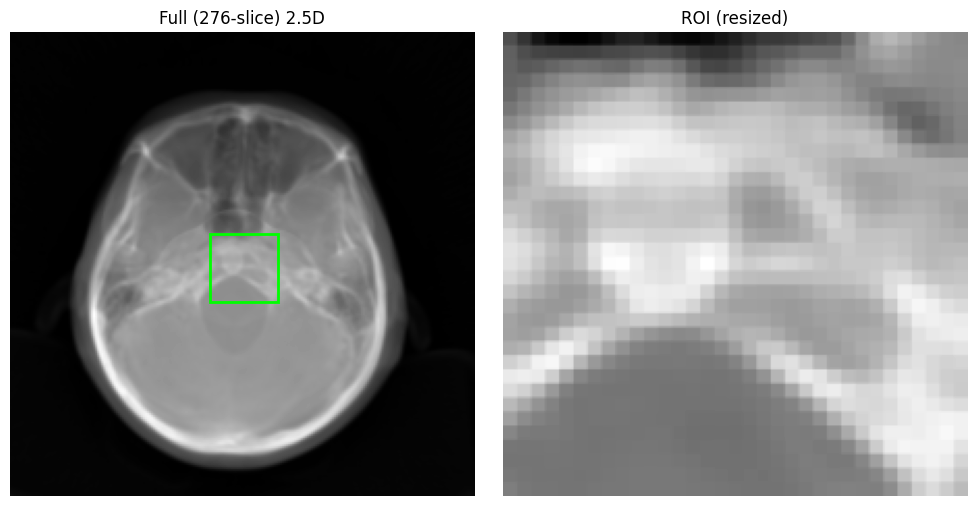

In [ ]:
# ==== Preview full image and ROI from cache ====


def show_cached_full_and_roi(
    sid: str,
    cache_dir: str = CACHE_DIR,
    img_size: int = IMG_SIZE,
    roi_box_frac: float = 0.15,
    roi_min_px: int = 24,
):
    # Load cached CHW and coords (support .npy and .npz)
    img_path_npz = os.path.join(cache_dir, f"{sid}_img.npz")
    img_path_npy = os.path.join(cache_dir, f"{sid}_img.npy")
    img_path = img_path_npz if os.path.exists(img_path_npz) else img_path_npy
    img_chw = load_cached_img(img_path)  # [C,H,W]
    coords_path = os.path.join(cache_dir, f"{sid}_coords.npy")
    coords = np.load(coords_path).astype(np.float32) if os.path.exists(coords_path) else np.array([0.0, 0.0], dtype=np.float32)

    # CHW -> HWC
    img_hwc = np.transpose(np.asarray(img_chw), (1, 2, 0)).astype(np.float32, copy=False)

    # Visualization image (grayscale): mean over channels
    vis_full = img_hwc.mean(axis=2)

    # Compute ROI box using actual image size
    H, W = img_hwc.shape[:2]
    side = min(H, W)
    if valid_coords(coords):
        cx, cy = coords_to_px(coords, side)
        x1, y1, x2, y2 = make_bbox_px(cx, cy, side, roi_box_frac, roi_min_px)
        vis_roi_hwc = crop_and_resize_hwc(img_hwc, x1, y1, x2, y2, img_size)
        vis_roi = vis_roi_hwc.mean(axis=2)
    else:
        # Fallback: show full image as ROI if coords invalid
        x1 = y1 = 0
        x2 = W - 1
        y2 = H - 1
        vis_roi = vis_full

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(vis_full, cmap="gray")
    axs[0].set_title(f"Full ({img_chw.shape[0]}-slice) 2.5D")
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="lime", facecolor="none"
    )
    axs[0].add_patch(rect)
    axs[0].axis("off")

    axs[1].imshow(vis_roi, cmap="gray")
    axs[1].set_title("ROI (resized)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
# Pick a SeriesInstanceUID present in your cache
df = pd.read_csv(TRAIN_CSV)
df = df[df['Modality'] == 'CTA']

example_sid = str(df.iloc[0][ID_COL])
show_cached_full_and_roi(example_sid)

# Random Showing of slices from a series

1.2.826.0.1.3680043.8.498.65817788038525568300708140437795040709


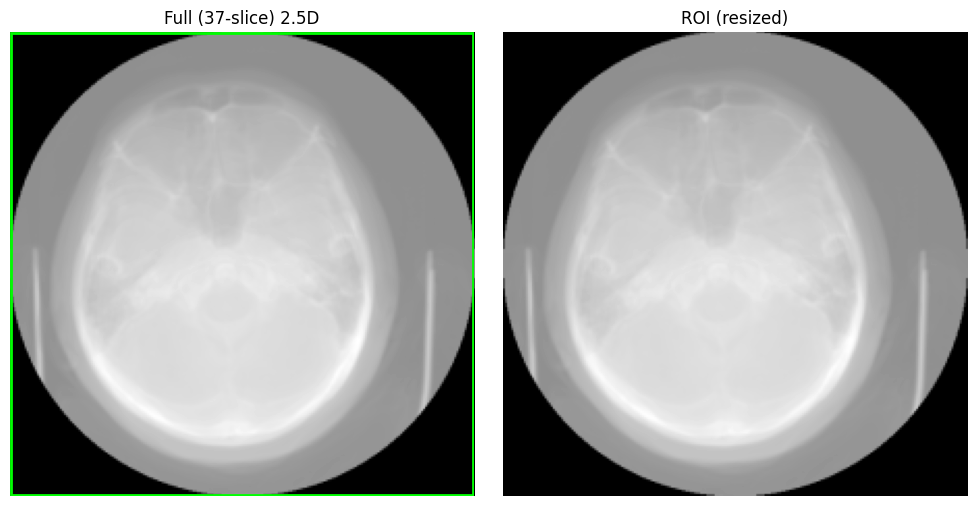

In [ ]:

sid = os.path.basename(np.random.choice([p for p in os.listdir(CACHE_DIR) if p.endswith('_img.npy') or p.endswith('_img.npz')])).replace('_img.npy','').replace('_img.npz','')
print(sid)
show_cached_full_and_roi(sid)

# Example Series with Slices that do not have ROI

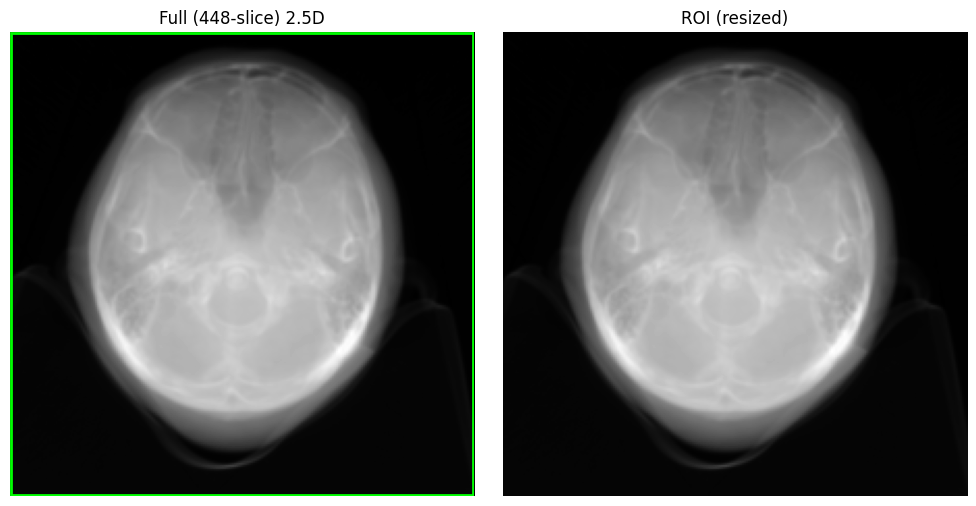

In [ ]:
#no ROI
show_cached_full_and_roi("1.2.826.0.1.3680043.8.498.99348616762869189162377000017558094817")

In [ ]:
def debug_roi_bbox(sid: str, cache_dir: str = CACHE_DIR):
    import numpy as np, os
    img_path_npz = os.path.join(cache_dir, f"{sid}_img.npz")
    img_path_npy = os.path.join(cache_dir, f"{sid}_img.npy")
    img_path = img_path_npz if os.path.exists(img_path_npz) else img_path_npy
    img_chw = load_cached_img(img_path)
    coords_path = os.path.join(cache_dir, f"{sid}_coords.npy")
    coords = np.load(coords_path).astype(np.float32) if os.path.exists(coords_path) else np.array([0.0, 0.0], dtype=np.float32)
    print("img shape (C,H,W):", img_chw.shape, "coords:", coords)

    H = W = img_chw.shape[1]
    cx, cy = coords_to_px(coords, W)
    x1, y1, x2, y2 = make_bbox_px(cx, cy, W, box_frac=0.15, min_px=24)
    print("px center:", (cx, cy), "bbox:", (x1, y1, x2, y2))

    if (x2 - x1) < 2 or (y2 - y1) < 2:
        print("ROI degenerated → fallback to full image")
    if not valid_coords(coords):
        print("coords invalid per valid_coords → ROI fallback to full image")

# Model Definition

In [ ]:

# Minimal cached dataset (uses mmap for low-RAM I/O)

# Example transforms (no ToTensorV2; we convert to tensor ourselves)
train_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.95,1.05),
        translate_percent={'x':(-0.05,0.05),'y':(-0.05,0.05)},
        rotate=(-10,10),
        p=0.5
    ),
    A.GaussianNoise(var_limit=(1.0, 5.0), mean=0, p=0.2) if hasattr(A, "GaussianNoise") else A.GaussNoise(p=0.2),
    A.MotionBlur(blur_limit=3, p=0.1),
])
val_tf = None  # keep cached normalization; or add light Normalize if desired

# ===== 2) Hybrid (full + ROI) Cached Dataset with Albumentations =====
class HybridCachedNPYDatasetAlb(Dataset):
    def __init__(self, df: pd.DataFrame, id_col: str, img_size: int,
                 roi_box_frac: float = 0.2, roi_min_px: int = 10,
                 transform: A.Compose | None = None):
        # Filter to SIDs that have cached image files
        all_files = []
        try:
            all_files = os.listdir(CACHE_DIR)
        except Exception:
            all_files = []
        avail = ({f.replace('_img.npy', '') for f in all_files if f.endswith('_img.npy')} |
                 {f.replace('_img.npz', '') for f in all_files if f.endswith('_img.npz')})
        df = df[df[id_col].astype(str).isin(avail)].reset_index(drop=True)

        self.df = df
        self.id_col = id_col
        self.img_size = img_size
        self.roi_box_frac = roi_box_frac
        self.roi_min_px = roi_min_px
        # Use additional_targets to apply the same augmentation to both full and ROI
        if transform is None:
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.Affine(
                        scale=(0.95,1.05),
                        translate_percent={'x':(-0.05,0.05),'y':(-0.05,0.05)},
                        rotate=(-10,10),
                        p=0.5,
                    ),
                ],
                additional_targets={"image2": "image"},
            )
        else:
            # Ensure additional_targets exists
            self.transform = A.Compose(transform.transforms, additional_targets={"image2": "image"})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        sid = str(row[self.id_col])

        img_path_npz = os.path.join(CACHE_DIR, f"{sid}_img.npz")
        img_path_npy = os.path.join(CACHE_DIR, f"{sid}_img.npy")
        img_path = img_path_npz if os.path.exists(img_path_npz) else img_path_npy
        coord_path = os.path.join(CACHE_DIR, f"{sid}_coords.npy")

        img_chw = load_cached_img(img_path)              # [C,H,W]
        # Robust to missing coords file
        try:
            coords = np.load(coord_path).astype(np.float32)     # [2]
        except FileNotFoundError:
            coords = np.array([0.0, 0.0], dtype=np.float32)

        # Take a fixed window of slices to produce consistent channels (WINDOW_LEN)
        C_all = img_chw.shape[0]
        center = C_all // 2
        img_win = take_window(img_chw, center, OFFSETS)  # [WINDOW_LEN, H, W]

        # Full image HWC from window
        img_full_hwc = np.transpose(np.asarray(img_win), (1, 2, 0)).astype(np.float32, copy=False)

        # ROI image HWC from window
        if valid_coords(coords):
            cx, cy = coords_to_px(coords, self.img_size)
            x1, y1, x2, y2 = make_bbox_px(cx, cy, self.img_size, self.roi_box_frac, self.roi_min_px)
            img_roi_hwc = crop_and_resize_hwc(img_full_hwc, x1, y1, x2, y2, self.img_size)
        else:
            img_roi_hwc = img_full_hwc

        # Ensure same H,W for both streams before augmentation
        img_full_hwc = img_full_hwc.astype(np.float32, copy=False)
        img_roi_hwc  = img_roi_hwc.astype(np.float32, copy=False)
        img_full_hwc = np.ascontiguousarray(img_full_hwc)
        img_roi_hwc  = np.ascontiguousarray(img_roi_hwc)
        img_full_hwc = cv2.resize(img_full_hwc, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        img_roi_hwc  = cv2.resize(img_roi_hwc,  (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)

        # Augment both consistently
        aug = self.transform(image=img_full_hwc, image2=img_roi_hwc)
        img_full_hwc = aug["image"]
        img_roi_hwc = aug["image2"]

        # Back to CHW and tensors
        x_full = torch.from_numpy(np.transpose(img_full_hwc, (2, 0, 1)).copy()).float()
        x_roi  = torch.from_numpy(np.transpose(img_roi_hwc,  (2, 0, 1)).copy()).float()

        vals = pd.to_numeric(row[LABEL_COLS], errors="coerce").values.astype(np.float32)
        vals = np.nan_to_num(vals, nan=0.0)
        y = torch.from_numpy(vals)

        c = torch.from_numpy(coords)
        return x_full, x_roi, y, c

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBackbone(nn.Module):
    """U-Net编码器，支持通过参数调整网络深度"""
    def __init__(self, in_chans=5, base_chans=64, depth=4):
        super().__init__()
        layers = []
        current_chans = in_chans

        # 根据深度构建不同复杂度的U-Net
        for i in range(depth):
            # 通道数翻倍
            next_chans = base_chans * (2 ** i) if i > 0 else base_chans
            layers.extend([
                nn.Conv2d(current_chans, next_chans, kernel_size=3, padding=1),
                nn.BatchNorm2d(next_chans),
                nn.ReLU(inplace=True),
                nn.Conv2d(next_chans, next_chans, kernel_size=3, padding=1),
                nn.BatchNorm2d(next_chans),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)  # 下采样
            ])
            current_chans = next_chans

        # 最终层固定为1280通道，匹配原始模型
        layers.extend([
            nn.Conv2d(current_chans, 1280, kernel_size=3, padding=1),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True)
        ])

        self.encoder = nn.Sequential(*layers)
        self.feature_info = [{'num_chs': 1280}]

    def forward(self, x):
        return [self.encoder(x)]


class HybridAneurysmModel(nn.Module):
    # 保留base_model_name参数以兼容训练代码，但实际使用U-Net
    def __init__(self, base_model_name="unet_backbone", num_classes=14):
        super().__init__()

        # 可以根据base_model_name调整U-Net的深度
        depth_map = {
            "unet_backbone": 4,  # 对应原始模型的复杂度
            "unet_small": 3,
            "unet_large": 5
        }
        depth = depth_map.get(base_model_name, 4)  # 默认深度

        # 1. U-Net编码器（兼容原始in_chans=5）
        self.backbone = UNetBackbone(
            in_chans=5,
            depth=depth
        )

        # 2. 最终层通道数（与原始逻辑一致）
        enc_dim = self.backbone.feature_info[-1]['num_chs']

        # 3. 坐标小网络（与原始完全一致）
        self.coord_fc = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 64)
        )

        # 4. 分类头（与原始完全一致）
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(enc_dim * 2 + 64, num_classes)
        )

    def forward(self, x_full: torch.Tensor, x_roi: torch.Tensor, coords: torch.Tensor):
        # 与原始模型前向传播完全一致
        feat_full = self.backbone(x_full)[-1]
        feat_roi  = self.backbone(x_roi)[-1]

        att_full = torch.softmax(feat_full.view(*feat_full.shape[:2], -1), dim=-1) \
                          .view_as(feat_full)
        att_roi  = torch.softmax(feat_roi.view(*feat_roi.shape[:2], -1), dim=-1) \
                          .view_as(feat_roi)

        g_full = (feat_full * att_full).sum(dim=(2, 3))
        g_roi  = (feat_roi  * att_roi).sum(dim=(2, 3))

        f_coord = self.coord_fc(coords.float())

        fused = torch.cat([g_full, g_roi, f_coord], dim=1)
        return self.classifier(fused)


# Model Training Configurations

In [ ]:


df = pd.read_csv(TRAIN_CSV)
df = df[df['Modality'] == 'CTA']

# Keep only SIDs present in cache
try:
    files = os.listdir(CACHE_DIR)
    cache_ids_npy = {f.replace('_img.npy','') for f in files if f.endswith('_img.npy')}
    cache_ids_npz = {f.replace('_img.npz','') for f in files if f.endswith('_img.npz')}
    cache_ids = cache_ids_npy | cache_ids_npz
    df = df[df[ID_COL].astype(str).isin(cache_ids)].reset_index(drop=True)
    print(f"Using {len(df)} CTA rows present in cache ({CACHE_DIR})")
except Exception as e:
    print(f"Warning: could not list cache dir {CACHE_DIR}: {e}")

DEBUG_FAST = False
if DEBUG_FAST:
    SUBSET_PER_CLASS = 50
    df = (df.groupby('Aneurysm Present', group_keys=False)
            .apply(lambda x: x.sample(min(len(x), SUBSET_PER_CLASS), random_state=42))
            .reset_index(drop=True))
else:
    df.reset_index(drop=True, inplace=True)

if len(df) == 0:
    raise ValueError(f"No CTA rows found in cache after filtering. Check CACHE_DIR ({CACHE_DIR}) and ensure files end with '_img.npy' or '_img.npz'.")

if USE_CV:
    df['fold'] = -1
    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(df, df['Aneurysm Present'])):
        df.loc[val_idx, 'fold'] = fold
else:
    df['fold'] = 0

# Training Loop with modifications to handle invalid samples
criterion = nn.BCEWithLogitsLoss()

def train_architecture(arch):
    for fold in range(NUM_FOLDS if USE_CV else 1):
        print(f"🔁 Training {arch} (hybrid) | Fold {fold}")
        train_df = df[df['fold'] != fold]
        val_df   = df[df['fold'] == fold]

        # Version-safe noise: prefer GaussianNoise if available; else fallback to GaussNoise without extra args
        noise_tf = A.GaussianNoise(var_limit=(1.0, 5.0), mean=0, p=0.2) if hasattr(A, "GaussianNoise") else A.GaussNoise(p=0.2)

        # For hybrid (apply same aug to full and ROI)
        hybrid_tf = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.Affine(
                    scale=(0.95, 1.05),
                    translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                    rotate=(-10, 10),
                    p=0.5
                ),
                noise_tf,
            ],
            additional_targets={'image2': 'image'}
        )

        train_ds = HybridCachedNPYDatasetAlb(train_df, id_col=ID_COL, img_size=IMG_SIZE,
                                             roi_box_frac=0.15, roi_min_px=24, transform=hybrid_tf)
        val_ds   = HybridCachedNPYDatasetAlb(val_df,   id_col=ID_COL, img_size=IMG_SIZE,
                                             roi_box_frac=0.15, roi_min_px=24, transform=None)

        train_loader = make_loader(train_ds, True,  NUM_WORKERS)
        val_loader   = make_loader(val_ds,   False, max(1, SAFE_WORKERS//2) if SAFE_WORKERS>0 else 0)

        model = HybridAneurysmModel(base_model_name=arch)
        if USE_MULTIGPU:
            model = nn.DataParallel(model)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.BCEWithLogitsLoss()

        best_wauc = -1.0
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0.0
            pbar = tqdm(train_loader, total=len(train_loader),
                        desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False,
                       file=sys.stderr)
            for step, (x_full, x_roi, y, coords) in enumerate(pbar):
                x_full = x_full.to(device, non_blocking=True)
                x_roi  = x_roi.to(device, non_blocking=True)
                y      = y.to(device, non_blocking=True)
                coords = coords.to(device, non_blocking=True)

                optimizer.zero_grad()
                logits = model(x_full, x_roi, coords)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if (step + 1) % 10 == 0:
                    pbar.set_postfix(loss=running_loss / (step + 1))

            model.eval()
            all_probs, all_targets = [], []
            for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="val(all-slices)"):
                sid = str(row[ID_COL])
                y   = pd.to_numeric(row[LABEL_COLS], errors="coerce").fillna(0.0).values.astype(np.float32)
                p   = infer_series_all_slices(model, sid, cache_dir=CACHE_DIR, img_size=IMG_SIZE, offsets=OFFSETS,
                                            batch_size=16, aggregate="max", use_roi=True)
                all_probs.append(p)
                all_targets.append(y)

            all_probs = np.asarray(all_probs, dtype=np.float32)
            all_targets = np.asarray(all_targets, dtype=np.float32)

            assert all_probs.ndim == 2 and all_targets.ndim == 2
            assert all_probs.shape[1] == len(LABEL_COLS) and all_targets.shape[1] == len(LABEL_COLS)

            wAUC, ap_auc, others_mean, per_class_auc, skipped = compute_weighted_auc(all_targets, all_probs, LABEL_COLS)
            print(f"Skipped {len(skipped)}: {skipped}")
            print(f"Epoch {epoch+1}/{EPOCHS} | train {running_loss/ max(1,len(train_loader)):.4f} | "
                  f"wAUC {wAUC:.4f} | AP {ap_auc:.4f} | others {others_mean:.4f}")

            if not np.isnan(wAUC) and wAUC > best_wauc:
                best_wauc = wAUC
                torch.save(model.module.state_dict() if USE_MULTIGPU else model.state_dict(),
                           f"{arch}_fold{fold}_best_wAUC.pth")

            del all_probs, all_targets  # and any large tensors like logits/x/y/coords/x_full/x_roi
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()  # helps fragmentation; doesn't hurt correctness

        model_path = f"{arch}_hybrid_fold{fold}.pth"
        torch.save(model.module.state_dict() if USE_MULTIGPU else model.state_dict(), model_path)
        print(f"💾 Saved: {model_path}")



# Training

In [ ]:
RUN_TRAIN = True #False to load trained models

if RUN_TRAIN:
    for arch in ARCHITECTURES:
        train_architecture(arch)
else:
    models = []
    for arch in ARCHITECTURES:
        for fold in range(NUM_FOLDS):
            p = f"{arch}_fold{fold}.pth"
            if os.path.exists(p):
                models.append(load_trained_aneurysm_model(p, arch))